In [1]:
import torch
import numpy as np
from model import LIDCT, FCIDCT, FCCNNIDCT, DECNNIDCT, RESIDCT, RESJPEGDECODER
import matplotlib.pyplot as plt
import cv2
from utils.jpeg import JPEG
from utils.metrics import psnr
import math
import os
def psnr(img1, img2):
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))
# plt.style.use('dark_background')


In [2]:
#filename = "testset_50000_8"
model_type = "res_dec"
qf = 1
modelname = f"jpeg_model_color_{qf}"
jpeg = JPEG(qf, True)
size = 8

In [3]:
train_on_gpu = torch.cuda.is_available()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# dctDataset = DCTDataset(filename=filename)
# test_loader = DataLoader(dataset=dctDataset,
#                         batch_size=3,
#                         shuffle=True,
#                         num_workers=8,
#                         pin_memory=True)
if model_type == "fc":
    model = FCIDCT(size=size)
elif model_type == "cnn":
    model = LIDCT()
elif model_type == "fc_cnn":
    model = FCCNNIDCT(size=size)
elif model_type == "decnn":
    model = DECNNIDCT(num_channels=64, size=size)
elif model_type == "res":
    model = RESIDCT(num_channels=64, size=size)
elif model_type == "res_dec":
        model = RESJPEGDECODER()

model.to(device)
model.load_state_dict(torch.load(f"./weights/{modelname}.pth"))
model.eval()
# test_set = load_file("data", filename)
# print(len(dctDataset))

RESJPEGDECODER(
  (crcbblock): Sequential(
    (0): ConvTranspose2d(32, 128, kernel_size=(8, 8), stride=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (block1): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(8, 8), stride=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (block2): ResidualBlock(
    (conv1): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gdn1): GDN()
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gdn2): GDN()
  )
  (block3): ResidualBlock(
    (conv1): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gdn1): GDN()
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gdn2): GDN()
  )
  (block4): ResidualBlock(
    (conv1): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gdn1): GDN()
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(192, 19

In [4]:
data_path = "../../dataset/DIV2K_valid_HR"
test_images = [i for i in os.listdir(data_path) if i.endswith("4x_lr.png")]
name = test_images[0]
img = np.float32(cv2.cvtColor(cv2.imread(f"{data_path}/{name}"), cv2.COLOR_BGR2YCR_CB))
w = img.shape[1]
h = img.shape[0]
batch_size = 1000
img = img[:h//8*8, :w//8*8]
jpeg_recon = np.zeros(img.shape)
res_recon = np.zeros(img.shape)
quan_recon = []
for y in range(0, img.shape[0] - size + 1, size):
        for x in range(0, img.shape[1] - size + 1, size):
            mcu = img[y:y+size,x:x+size]
            dct = jpeg.dct(mcu)
            quan = jpeg.quanti(dct)
            chw = quan.transpose(2, 0, 1)
            yy = chw[0].reshape(64, 1, 1)
            cr = cv2.resize(chw[1], (4, 4), interpolation=cv2.INTER_AREA).reshape(16, 1, 1)
            cb = cv2.resize(chw[2], (4, 4), interpolation=cv2.INTER_AREA).reshape(16, 1, 1)
            quan_recon.append(np.concatenate((yy, cr, cb)))
            decoded_mcu = jpeg.decode_mcu(quan)
            jpeg_recon[y:y+size,x:x+size] = decoded_mcu

ipt = torch.from_numpy(np.array(quan_recon)[:batch_size]).to(device, dtype=torch.float)
opt = model(ipt)
c=0
start = 0
for y in range(img.shape[0]//8):
    for x in range(img.shape[1]//8):
        if (c % batch_size) == 0:
            start = c//batch_size * batch_size
            ipt = torch.from_numpy(np.array(quan_recon)[start:start + batch_size]).to(device, dtype=torch.float)
            opt = model(ipt)
        test = opt[y*img.shape[1]//8+x - start].cpu().detach().numpy()*255
        res_recon[y*8:y*8+size,x*8:x*8+size] = test.transpose(1,2,0)
        c+=1


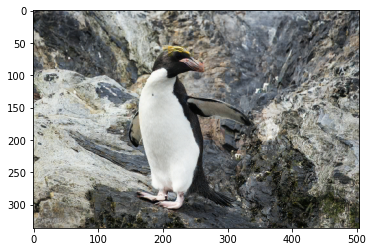

In [5]:
plt.imshow(cv2.cvtColor(res_recon.astype('uint8'), cv2.COLOR_YCR_CB2RGB))
plt.show()

(672, 1016, 3)

In [14]:
data_path = "../dataset/DIV2K_valid_HR"
test_images = [i for i in os.listdir(data_path) if i.endswith("lr.png")]
for name in test_images:
    img = np.float32(cv2.imread(f"{data_path}/{name}", cv2.IMREAD_GRAYSCALE))
    w = img.shape[1]
    h = img.shape[0]
    img = img[:h//8*8, :w//8*8]
    jpeg_recon = np.zeros((img.shape[0], img.shape[1]))
    res_recon = np.zeros((img.shape[0], img.shape[1]))
    quan_recon = []
    for y in range(0, img.shape[0] - size + 1, size):
        for x in range(0, img.shape[1] - size + 1, size):
            mcu = img[y:y+size,x:x+size]
            dct = jpeg.dct(mcu)
            quan = jpeg.quanti(dct)
            quan_recon.append(quan)
            decoded_mcu = jpeg.decode_mcu(quan)
            jpeg_recon[y:y+size,x:x+size] = decoded_mcu
    print(len(quan_recon))
    quan_recon = torch.from_numpy(np.array(quan_recon)).to(device, dtype=torch.float)
    ipt = quan_recon.reshape(-1, 64, 1, 1)
    opt = model(ipt)
    for y in range(img.shape[0]//8):
        for x in range(img.shape[1]//8):
            res_recon[y*8:y*8+size,x*8:x*8+size] = opt[y*img.shape[1]//8+x].cpu().detach().numpy()*255
    print(name)
    print(np.sum((jpeg_recon - img)**2))
    print(np.sum((res_recon - img)**2))
    print(psnr(img, jpeg_recon))
    print(psnr(img, res_recon))
    torch.cuda.empty_cache()
    # cv2.imwrite(f"jpeg_result/{name}_crop.png", img)
    # cv2.imwrite(f"jpeg_result/{name}_jpeg_recon.png", jpeg_recon)
    # cv2.imwrite(f"jpeg_result/{name}_res_recon.png", res_recon)

0848_4x_lr.png
75336249.0
63154699.48141613
22.22838128844723
22.99436448770475
0850_4x_lr.png
54250756.0
48784225.94138399
23.074443801211338
23.5357075626698
0869_4x_lr.png
76799382.0
72926726.7801126
21.564924493992375
21.789634534375075
0900_4x_lr.png
76294542.0
65622175.4049133
20.92409914798873
21.578527617247122


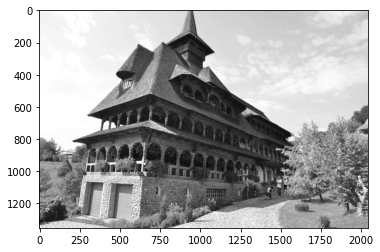

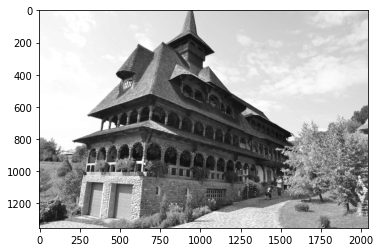

True

In [29]:
plt.imshow(jpeg_recon, cmap="gray", vmin=0, vmax=255)
plt.show()
plt.imshow(res_recon, cmap="gray", vmin=0, vmax=255)
plt.show()
cv2.imwrite("jpeg_result/0834_jpeg_recon.png", jpeg_recon)
cv2.imwrite("jpeg_result/0834_res_recon.png", res_recon)

In [30]:
import math
def psnr(img1, img2):
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

In [31]:
print(np.sum((jpeg_recon - img)**2))
print(np.sum((res_recon - img)**2))
print(psnr(img, jpeg_recon))
print(psnr(img, res_recon))

109626372.0
92969580.75760894
32.13772178193055
32.853463473686574


In [4]:
# img = np.float32(cv2.imread("test_image/0834.png", cv2.IMREAD_GRAYSCALE))
# # recon = torch.from_numpy(np.zeros(img.shape)).to(device)
# recon = np.zeros((img.shape[0]//size*size, img.shape[1]//size*size))

# for i in range(0, img.shape[0] - size + 1, size):
#     for j in range(0, img.shape[1] - size + 1, size):
#         #x = torch.from_numpy(dct(img[i:i+size, j:j+size], norm="ortho").reshape((1, 1, size, size))).to(device)
#         # x = torch.from_numpy(cv2.dct(img[i:i+size, j:j+size]).reshape((1, 1, size, size))).to(device)
#         x = torch.from_numpy(cv2.dct(img[i:i+size, j:j+size]).reshape((1, 64, 1, 1))).to(device)
#         output = model(x)
#         recon[i:i+size, j:j+size] = output[0].cpu().detach().numpy()
        
# print(recon[0])

[0.96831119 0.97512496 0.97017968 ... 0.80443615 0.81238699 0.8133918 ]


In [5]:
#test = recon.cpu().detach().numpy()
# test = recon
# print(test.shape)

(1352, 2040)


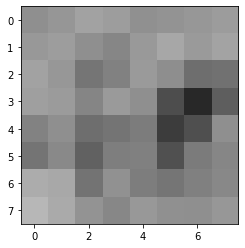

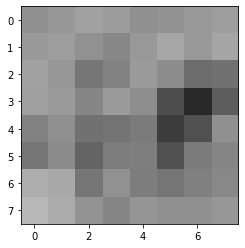

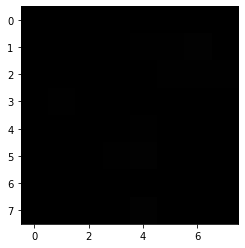

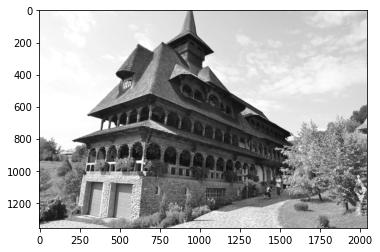

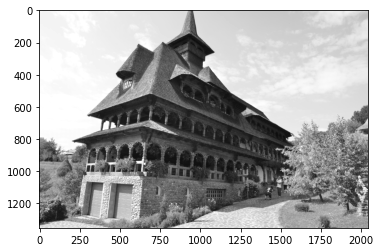

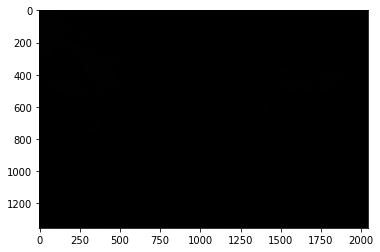

In [6]:
# print(test_set["y"][0].shape)
# norm="ortho"
# plt.imshow(test_set["y"][n][0]*255, cmap="gray", vmin=0, vmax=255)
# plt.show()
# plt.imshow(test_set["x"][n][0])
# plt.show()
# plt.imshow(idct(test_set["x"][n][0], norm="ortho")*255, cmap="gray", vmin=0, vmax=255)
# plt.show()
# plt.imshow(idct()*255, cmap="gray")
# plt.show()
# plt.imshow(output.cpu().detach().numpy()[0][0]*255, cmap="gray", vmin=0, vmax=255)
y_pos, x_pos = 288, 560
#fig = plt.figure()
#plt.plot()
#plt.imshow()

plt.imshow(img[y_pos:y_pos + size, x_pos:x_pos + size]*255, cmap="gray", vmin=0, vmax=255)
plt.show()
plt.imshow(test[y_pos:y_pos + size, x_pos:x_pos + size]*255, cmap="gray", vmin=0, vmax=255)
plt.show()
plt.imshow(img[y_pos:y_pos + size, x_pos:x_pos + size]*255-test[y_pos:y_pos + size, x_pos:x_pos + size]*255, cmap="gray", vmin=0, vmax=255)
plt.show()
plt.imshow(img*255, cmap="gray", vmin=0, vmax=255)
plt.show()
plt.imshow(test*255, cmap="gray", vmin=0, vmax=255)
plt.show()
plt.imshow(img[:1352, :]*255-test[:1352, :]*255, cmap="gray", vmin=0, vmax=255)
plt.show()

# val_one_epoch(1)

In [7]:
cv2.imwrite(f"./output/{outputimagename}.png", test*255)

True

In [8]:
cv2.imwrite(f"test_diff.png", img[:1352, :]*255-test[:1352, :]*255)

True

In [23]:
cv2.imwrite("gray.png", img[:1352, :]*255)

True

In [25]:
 img[:1352, :].shape

(1352, 2040)